<a href="https://colab.research.google.com/github/variable-jain/Deep-learning-experiments-with-pytorch-and-fastai/blob/main/Convolutional_Neural_Networks_in_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [4]:
from fastai.vision.all import *

## Our first Convolutional Neural Network

In [ ]:
path = untar_data(URLs.MNIST_SAMPLE)

In [7]:
mnist = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(),
    get_y=parent_label)
dls = mnist.dataloaders(path)

In [9]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, kernel_size=ks, padding=ks//2, stride=2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

In [10]:
simple_cnn = nn.Sequential(             # Input = (28,28)
    conv(1, 4),                         # (14,14)
    conv(4, 8),                         # (7,7)
    conv(8, 16),                        # (4,4)
    conv(16, 32),                       # (2,2)
    conv(32, 2, act=False),             # (1,1)
    Flatten()
)

In [12]:
learn = Learner(dls, simple_cnn, loss_func=F.cross_entropy, metrics=accuracy)

In [13]:
learn.summary()

Sequential (Input shape: 64)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 4 x 14 x 14    
Conv2d                                    40         True      
ReLU                                                           
____________________________________________________________________________
                     64 x 8 x 7 x 7      
Conv2d                                    296        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 16 x 4 x 4     
Conv2d                                    1168       True      
ReLU                                                           
____________________________________________________________________________
                     64 x 32 x 2 x 2     
Conv2d                                    4640       True      
ReLU                                                        

In [14]:
learn.fit_one_cycle(2, 0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.071414,0.036811,0.986752,00:11
1,0.019353,0.027057,0.990186,00:11


## Improving the CNN's training stability

In [15]:
path = untar_data(URLs.MNIST)
path.ls()

(#2) [Path('/root/.fastai/data/mnist_png/testing'),Path('/root/.fastai/data/mnist_png/training')]

In [17]:
def get_dls(bs=64):
    return DataBlock(
        blocks=[ImageBlock(cls=PILImageBW), CategoryBlock],
        get_items=get_image_files,
        get_y=parent_label,
        splitter=GrandparentSplitter('training', 'testing'),
        batch_tfms=Normalize()
    ).dataloaders(path, bs=bs)
dls = get_dls()

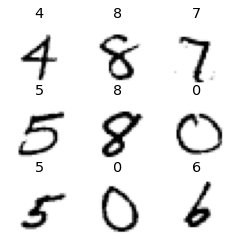

In [18]:
dls.show_batch(max_n=9, figsize=(4,4))

### Baseline

In [19]:
def simple_cnn():
    return sequential(
        conv(1, 8, ks=5),
        conv(8, 16),
        conv(16, 32),
        conv(32, 64),
        conv(64, 10, act=False),
        Flatten(),
    )

In [20]:
from fastai.callback.hook import *

In [21]:
def fit(epochs=1):
    learn = Learner(dls, simple_cnn(), loss_func=F.cross_entropy, 
                    metrics=accuracy, cbs=ActivationStats(with_hist=True))
    learn.fit(epochs, 0.06)
    return learn

In [22]:
learn = fit()

/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,2.305765,2.307673,0.097400,00:58


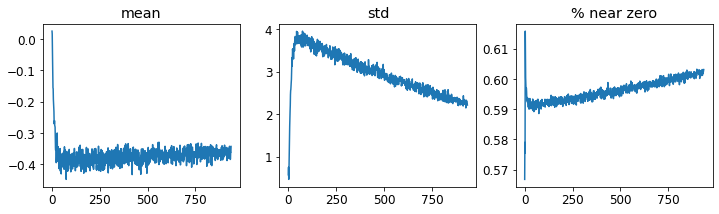

In [23]:
learn.activation_stats.plot_layer_stats(0)

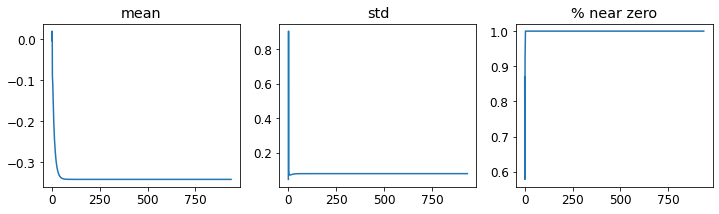

In [24]:
learn.activation_stats.plot_layer_stats(-2)

### Increasing Batch Size

In [25]:
dls = get_dls(512)

In [26]:
learn = fit()

/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,2.306541,2.302666,0.113500,00:50


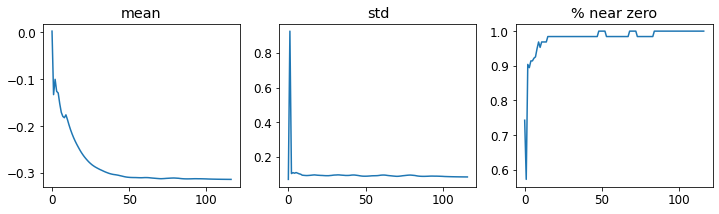

In [27]:
learn.activation_stats.plot_layer_stats(-2)

### 1Cycle Training

In [29]:
def fit(epochs=1, lr=0.06):
    learn = Learner(dls, simple_cnn(), loss_func=F.cross_entropy, 
                    metrics=accuracy, cbs=ActivationStats(with_hist=True))
    learn.fit_one_cycle(epochs, lr)
    return learn

In [30]:
learn = fit()

/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,0.198526,0.078045,0.973600,00:50


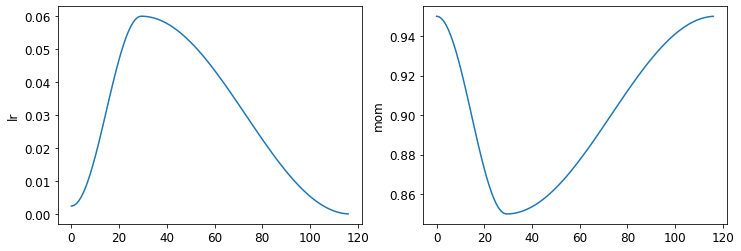

In [31]:
learn.recorder.plot_sched()

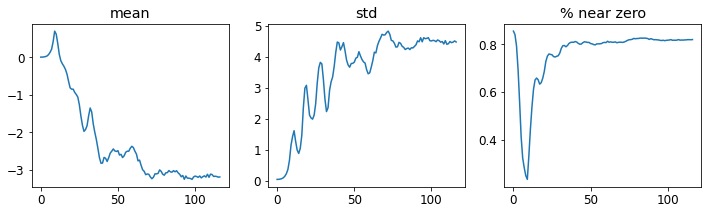

In [32]:
learn.activation_stats.plot_layer_stats(-2)

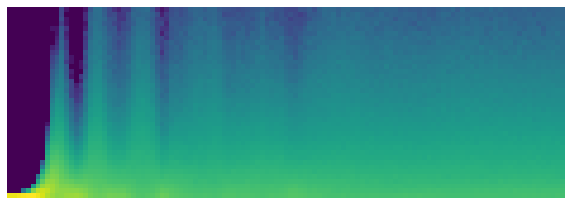

In [33]:
learn.activation_stats.color_dim(-2)

### Batch Normalization

In [34]:
def conv(ni, nf, ks=3, act=True):
    layers = [nn.Conv2d(ni, nf, kernel_size=ks, padding=ks//2, stride=2)]
    layers.append(nn.BatchNorm2d(nf))
    if act: layers.append(nn.ReLU())
    return nn.Sequential(*layers)

In [35]:
learn = fit()

/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,0.133873,0.056122,0.986200,00:53


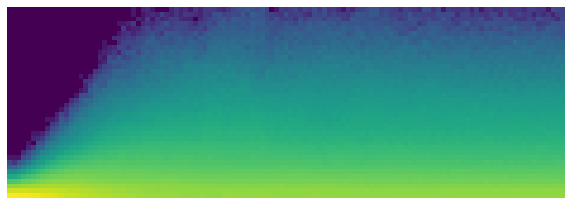

In [37]:
learn.activation_stats.color_dim(-4)

In [38]:
learn = fit(5, lr=0.1)

/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,0.188616,0.148309,0.957800,00:52
1,0.080838,0.072205,0.976200,00:52
2,0.054337,0.042101,0.986400,00:52
3,0.032397,0.034323,0.988500,00:52
4,0.016412,0.024811,0.991300,00:52
